####    Primero, importamos las librerías a usar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from mpl_toolkits.mplot3d import Axes3D
import math
import time
import os
import imageio


Un resultado util es que sabemos a beta muy menor a uno la varianza de un valor es menor o igual algo por log(n)
donde si mal no recuerdo n tamaño grilla, de todas formas ahora se cuanto más menos debo sumarl al bicho

In [6]:
# n es el radio de nuestra grilla entera.
def cotagrilla(n):
    return 2*np.log((2*n+1))

def cotagrilla2(n):
    return (2*n+1)**2

Aquí programamos la cota dada por el resutlado en "Harmonic pinnacles in the discrete Gaussian model",
recordemos esta cota es para b largo, i.e. temperatura baja.

Esto notemos no sirve tanto para la simulación sino más bien para ir viendo como vamos.

In [7]:
def unacota(b,m):
    l = 2*m+1
    c = 1/(2*np.pi*b)
    L = np.log(l)
    LL = np.log(L)
    return np.sqrt(c*L*LL)+1
unacota(0.1, 50)

4.351608833081746

In [8]:
def valor_inicial_1(m):
    l = 2*m+1
    x = np.zeros((l,l))
    for i in range(1, 2*m):
        for j in range(1, 2*m):
            x[i,j] = np.random.randint(-1*cotagrilla(m),cotagrilla(m)+1)
    return x

#def valor_inicial_2(m):
#    l = 2*m+1
#    x = np.zeros((l,l))
#
#
#
#   for i in range(1, 2*m):
#        for j in range(1, 2*m):
#            x[i,j] = np.random.randint(-1*cotagrilla(m),cotagrilla(m)+1)
#      return x

El problema actual es que el valor inicial dado no es próximo a la distribución invariante deseada, con lo que se debe
cambiar esta para que sea más razonable.

In [9]:
# primero veamos una función que nos de un valor inicial para nuestra cadena, empezaremos 
# con una forma simple de dar una configuración inicial
n =10

#vemos una función de transición simple también

def fun_tran(x, n, beta):
    y = np.copy(x)
    i = np.random.randint(1, 2*n)
    j = np.random.randint(1, 2*n)
    vecinos = sum([ x[i,j+1], x[i,j-1], x[i+1,j], x[i-1,j] ])
    d_x = 4
    rho = (1/d_x)
    c = rho*vecinos
    sigma = np.sqrt(1/4*beta)
    propuesta = np.random.normal(loc=c, scale = sigma)
    y[i, j] = np.floor(propuesta)
    return (i, j, y)

# este es un valor auxiliar que necesitaremos
def pi_xy(x,y, i, j):
    a = x[i,j]
    b = y[i,j]
    s = [x[i,j+1],x[i+1,j], x[i,j-1],x[i-1,j]]
    return 4*(b**2-a**2) - 2*(b-a)*sum(s)
#Aqui obtenemos lo que en el apunte se denomino pi_x/pi_y

def q(x,y, beta, i ,j):
    k = y[i,j]
    vecinos = sum([ x[i,j+1], x[i,j-1], x[i+1,j], x[i-1,j] ])
    d_x = 4
    rho = (1/d_x)
    c = rho*vecinos
    sigma = np.sqrt(1/(2*beta))
    c2 = (1/sigma**2)*(k+1-c)
    c1 = (1/sigma**2)*(k-c)
    b = math.erf(c2)
    a = math.erf(c1)
    return b-a

def Gibbs(b, x, y,i ,j ):
    h = pi_xy(x, y ,i, j)
    value = np.exp(-b*h)*(q(y,x, b, i ,j)/q(x,y, b, i ,j))
    return value

def Metropolis_Hasting(beta, N , m):
    X = []
    l =2*m+1
    x_0 = np.zeros((l,l))
    X.append(x_0)
    U = np.random.uniform(size = N)
    for i in range(N):
        x = X[i]
        (i, j, y) = fun_tran(x, m, beta)
        xy = Gibbs(beta, x, y, i, j)
        if U[i]<xy:
            X.append(y)
        else:
            X.append(x)
    return X

# Ahora programamos el algoritmo de Metropolis-Hasting.
def Metropolis_Hasting_2(beta, N , m):
    l = 2*m+1
    x_f = np.zeros((l,l))
    U = np.random.uniform(size = N)
    for i in range(N):
        x = x_f
        (i, j, y) = fun_tran(x, m, beta)
        xy = Gibbs(beta, x, y, i,j )
        if U[i]<xy:
            x_f = np.copy(y)
        else:
            x_f = x_f
    return x_f




### Testeos

In [11]:
%%time
k= 50
sim_1 =Metropolis_Hasting(1, 100000, k)
sim_1 = sim_1[-1]

CPU times: user 2.16 s, sys: 715 ms, total: 2.87 s
Wall time: 3.21 s


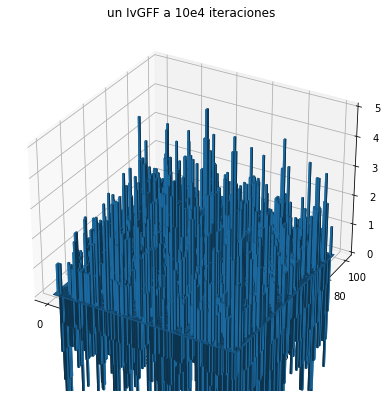

In [24]:
fig = plt.figure(figsize=(23, 23))
ax1 = fig.add_subplot(333, projection='3d')

l =2*k+1
_x = np.arange(l)
_y = np.arange(l)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = sim_1[x, y]
bottom = np.zeros_like(top)
width = depth = -1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('un IvGFF a 10e4 iteraciones')

plt.show()

A continuación veremos unas funciones que a un estado dado nos da una variable macroscopica asociada.

Aquí intentaremos una idea un poco más experimental y consiste en intentar ver el fenómeno descrito
en el libro de Velenik sobre la transición de fase de primer orden.

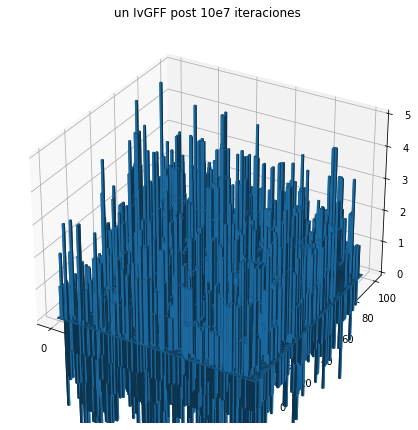

In [40]:
### ejemplo plot 3d
fig = plt.figure(figsize=(25, 25))
ax1 = fig.add_subplot(333, projection='3d')


_x = np.arange(101)
_y = np.arange(101)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = IvGFF2[x, y]
bottom = np.zeros_like(top)
width = depth = -1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('un IvGFF post 10e7 iteraciones')

plt.show()

# Simulaciones a realizar

In [13]:

def macro_1(x,n):
    s = np.sum(x)
    l = (2*n+1)**2
    return s/l

In [ ]:
%%time
n = 50
intervalo = np.linspace(0.1, 1, 100)
Fases = []
Fase = []
Macro_1 = []
for b in intervalo:
    IvGFF = Metropolis_Hasting(b, 20000, n)
    estados = IvGFF[10000::]
    estado_1 = estados[-1]
    estado_2 = estado_1**2
    lin = macro_1(estado_1, 50)
    Fases.append(estados)
    Fase.append(estado_1)
    Macro_1.append(lin**2)
    print(b)
print("listo")



0.1
0.1090909090909091
0.1181818181818182
0.1272727272727273
0.13636363636363635
0.14545454545454545
0.15454545454545454
0.16363636363636364
0.17272727272727273
0.18181818181818182
0.19090909090909092
0.2
0.2090909090909091
0.2181818181818182
0.22727272727272727
0.23636363636363636
0.24545454545454545
0.2545454545454545
0.26363636363636367
0.2727272727272727
0.28181818181818186
0.2909090909090909
0.3
0.3090909090909091
0.3181818181818182
0.32727272727272727
0.33636363636363636
0.34545454545454546
0.3545454545454545
0.36363636363636365
0.3727272727272727
0.38181818181818183
0.3909090909090909
0.4
0.40909090909090906
0.4181818181818182
0.42727272727272725
0.4363636363636364
0.44545454545454544
0.4545454545454546
0.4636363636363636
0.47272727272727266
0.4818181818181818
0.49090909090909085
0.5
0.509090909090909
0.5181818181818182
0.5272727272727272
0.5363636363636364
0.5454545454545454
0.5545454545454546
0.5636363636363636
0.5727272727272728
0.5818181818181818
0.5909090909090909
0.6
0.609

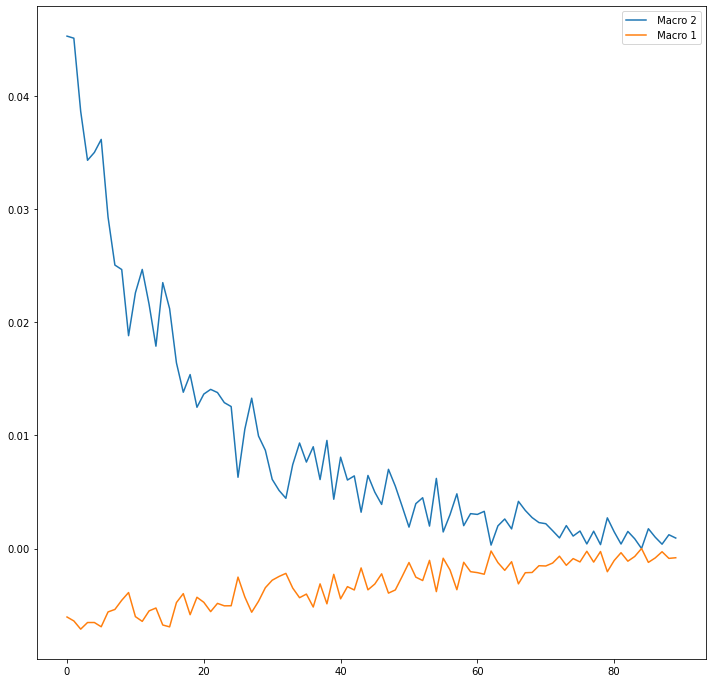

CPU times: user 99.9 ms, sys: 12.3 ms, total: 112 ms
Wall time: 114 ms


In [15]:
%%time
#intervalo = np.linspace(0.50001, 1, 50)
plt.figure(figsize=(12,12))
plt.plot(Macro_1[10::], label =" Macro 1")
plt.legend()
plt.show()

Ahora, para ahorrar trabajo en el futuro, veamos una función a la que le podamos entregar las
matrices de los estados y que nos de nuestro deseado gif :)

In [ ]:
fig = plt.figure(figsize=(25, 25))
ax1 = fig.add_subplot(333, projection='3d')


_x = np.arange(101)
_y = np.arange(101)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = I1[x, y]
bottom = np.zeros_like(top)
width = depth = -1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('un IvGFF')

plt.show()

In [23]:
n = len(Fases)
#n = 3
ind = []
for k in range(n):
    l = str(k)
    ind.append(l)

largo = np.arange(n)
indices = zip(i, largo)


In [ ]:
indices = zip(enum, largo)
for tau in indices:
    k = tau[0]
    l = tau[1]
    estado = Fases[l]
    fig = plt.figure(figsize=(25, 25))
    ax1 = fig.add_subplot(333, projection='3d')


    _x = np.arange(101)
    _y = np.arange(101)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    top = estado[x, y]
    bottom = np.zeros_like(top)
    width = depth = -1

    ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
    plt.savefig(k+".png")


In [ ]:
frames = []
for k in ind:
    frames.append(k+".png")

Construyamos nuestro gif